In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Scikit-learn preprocessing and model building tools
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor

In [2]:
# Load training and test datasets
dataset_train = pd.read_csv('train.csv')
dataset_test = pd.read_csv('test.csv')

In [3]:
#Prepare the datasets

# Remove 'Id' column from train and test (Id is just an identifier, not a feature)
dataset_train = dataset_train.drop("Id", axis=1)
dataset_test_n = dataset_test.drop("Id", axis=1)

# Store test IDs separately to be used later while saving predictions
test_Ids = dataset_test['Id']

# Split training data into features (X_train) and target (y_train)
X_train = dataset_train.drop('SalePrice', axis=1)
y_train = dataset_train['SalePrice']

In [4]:
# Combine both train and test features to ensure same preprocessing applied to both
combined = pd.concat([X_train, dataset_test_n], keys=["train", "test"])

# Handle missing values

# Identify numeric and categorical columns
numeric_columns = combined.select_dtypes(include=[np.number]).columns
categorical_columns = combined.select_dtypes(include=["object"]).columns

# Create imputers:

# For numeric columns: replace missing values with median
numeric_t = SimpleImputer(strategy='median')

# For categorical columns: replace missing values with constant value 'Missing'
categorical_t = SimpleImputer(strategy='constant', fill_value='Missing')

# Apply imputers to fill missing values
combined[numeric_columns] = numeric_t.fit_transform(combined[numeric_columns])
combined[categorical_columns] = categorical_t.fit_transform(combined[categorical_columns])

#  Encode categorical features

# Create a ColumnTransformer to apply OneHotEncoding to categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('encoder', OneHotEncoder(handle_unknown='ignore'), categorical_columns)],
    remainder='passthrough' # Leave numeric columns unchanged
)

# Apply transformation (OneHotEncoding + pass through numerics)
combined_transform = preprocessor.fit_transform(combined)

# Split back into train and test sets after transformation

# Get the number of rows in original training data
train_rows = X_train.shape[0]

# Split the combined transformed data back into training and test sets
X_train_split = combined_transform[:train_rows, :]
X_test_split = combined_transform[train_rows:, :]

In [5]:
# Train Random Forest Regression model

# Initialize Random Forest Regressor (ensemble model)
regressor = RandomForestRegressor(n_estimators = 10, random_state = 0)

# Fit model to training data
regressor.fit(X_train_split, y_train)

RandomForestRegressor(n_estimators=10, random_state=0)

In [6]:
# Predict on test data
predictions = regressor.predict(X_test_split)

# Save predictions to CSV file

#Create output dataframe with Id and predicted SalePrice
output = pd.DataFrame({'Id': test_Ids, 'SalePrice': predictions})

# Save to CSV
output.to_csv('house_price_predictions.csv', index=False)

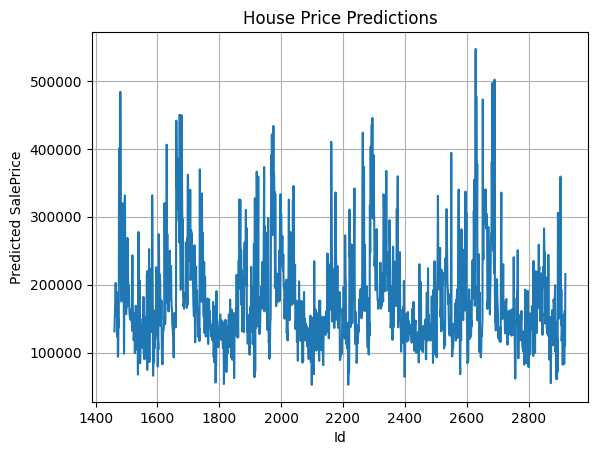

In [7]:
new_data = pd.read_csv('house_price_predictions.csv')
# Plot Id vs SalePrice
plt.plot(new_data['Id'], new_data['SalePrice'])
plt.xlabel('Id')
plt.ylabel('Predicted SalePrice')
plt.title('House Price Predictions')
plt.grid(True)
plt.show()